<a href="https://colab.research.google.com/github/ISHAPATIL24/Traverse_coderush1.0/blob/main/eegfilterr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne pyedflib numpy pandas matplotlib seaborn scipy pywt


ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [ ]:
!pip install mne pyedflib PyWavelets numpy pandas matplotlib seaborn scipy



In [ ]:
import mne
import pyedflib
import pywt

print("MNE version:", mne.__version__)
print("EDF working:", pyedflib.__version__)
print("Wavelets working:", pywt.__version__)


MNE version: 1.10.1
EDF working: 0.1.42
Wavelets working: 1.8.0


In [ ]:
import mne
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import pywt


In [ ]:
from google.colab import files

# Upload file manually
uploaded = files.upload()


Saving h02.edf to h02.edf


Extracting EDF parameters from /content/h02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 227499  =      0.000 ...   909.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp2, F8, T4, T6, O2, Fp1, F7, T3, T5, O1, F4, C4, P4, F3, C3, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2003-07-02 17:25:19 UTC
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: GMAZ>
>
Using matplotlib as 2D backend.


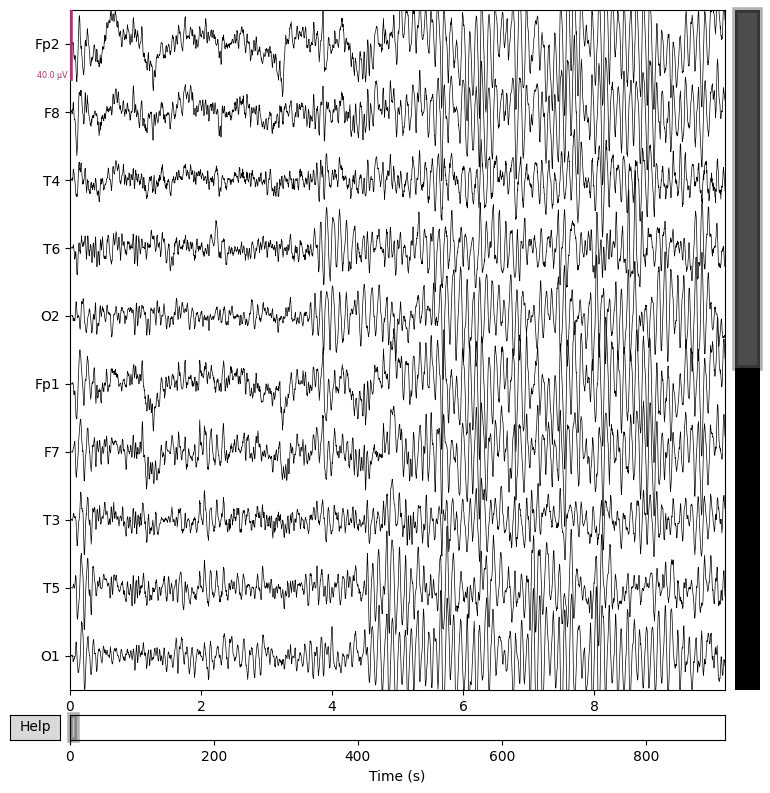

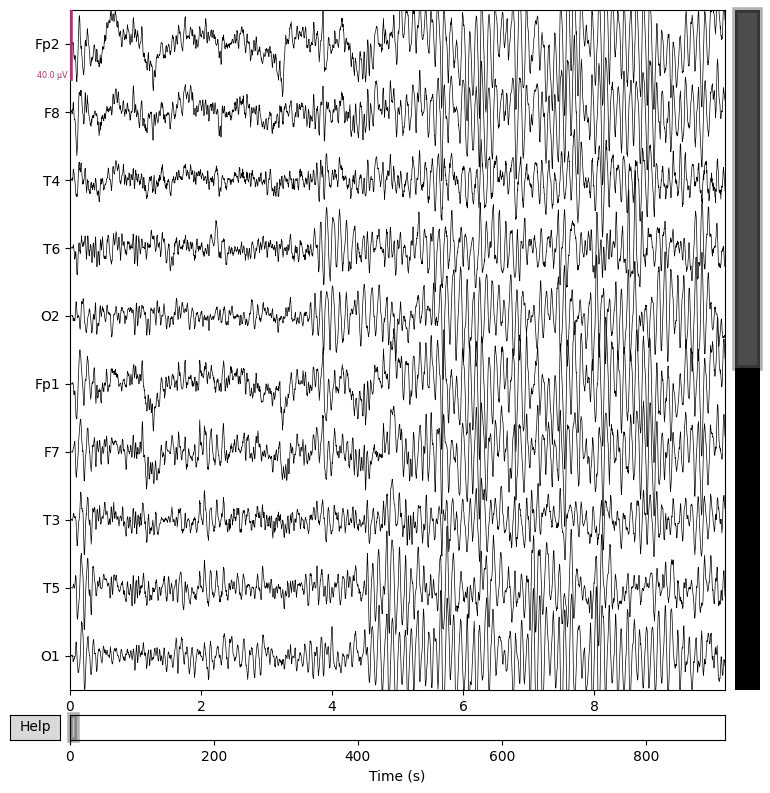

In [ ]:
import mne

# Example with MNE
raw = mne.io.read_raw_edf("h02.edf", preload=True)
print(raw.info)  # metadata about channels, sampling rate, etc.
raw.plot(duration=10, n_channels=10)  # visualize signals

In [ ]:
raw.filter(0.5, 45, fir_design='firwin')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 s)



<RawEDF | h02.edf, 19 x 227500 (910.0 s), ~33.0 MiB, data loaded>

In [ ]:
ica = mne.preprocessing.ICA(n_components=18, random_state=97)
ica.fit(raw)
raw = ica.apply(raw)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 18 components
Fitting ICA took 26.9s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


In [ ]:
events = mne.make_fixed_length_events(raw, duration=2.0)
epochs = mne.Epochs(raw, events, tmin=0, tmax=2, baseline=None)


Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
# If your mains is 50 Hz, use [50, 100]. For 60 Hz regions, use [60, 120]
raw.notch_filter(freqs=[50, 100])


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



<RawEDF | h02.edf, 19 x 227500 (910.0 s), ~33.0 MiB, data loaded>

In [ ]:
raw.set_eeg_reference('average')  # average reference is common


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | h02.edf, 19 x 227500 (910.0 s), ~33.0 MiB, data loaded>

In [ ]:
raw.resample(256)


<RawEDF | h02.edf, 19 x 232960 (910.0 s), ~33.8 MiB, data loaded>

In [ ]:
from mne.preprocessing import annotate_muscle_zscore
annot, scores = annotate_muscle_zscore(raw, ch_type='eeg', filter_freq=[110, 125])
raw.set_annotations(raw.annotations + annot)
raw = raw.copy().load_data().annotate(**{k: v for k, v in {}})  # ensures annotations applied
# Drop bad segments from epochs later by passing reject_by_annotation=True

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 126.50 Hz)
- Filter length: 283 samples (1.105 s)

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 423 samples (1.652 s)



AttributeError: 'RawEDF' object has no attribute 'annotate'

In [ ]:
import numpy as np
from scipy import signal
import pywt

BANDS = {'delta': (1,4), 'theta': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30,45)}

def welch_psd(x, fs):
    # x: [n_times]; returns f, Pxx
    f, Pxx = signal.welch(x, fs=fs, nperseg=min(256, len(x)))
    return f, Pxx

def bandpower(f, Pxx, lo, hi):
    idx = (f >= lo) & (f < hi)
    if not np.any(idx): return 0.0
    return np.trapz(Pxx[idx], f[idx])

def spectral_entropy_from_psd(Pxx):
    p = Pxx / (np.sum(Pxx) + 1e-12)
    return -np.sum(p * np.log2(p + 1e-12))

def peak_alpha_freq(f, Pxx):
    idx = (f >= 8) & (f <= 13)
    if not np.any(idx): return np.nan
    subf = f[idx]; subP = Pxx[idx]
    return float(subf[np.argmax(subP)])

def wavelet_energy(x, wavelet='db4', level=3):
    coeffs = pywt.wavedec(x, wavelet=wavelet, level=level)
    energies = np.array([np.sum(c**2) for c in coeffs], dtype=float)
    return energies  # length = level+1

# choose a few coherence pairs (adjust to your montage)
PAIR_NAMES = [('Fz','Cz'), ('F3','F4'), ('C3','C4'), ('P3','P4')]  # will use nearest matches

# map names to indices if available, else fallback to first channels
ch_names = raw.info['ch_names'] # Access channel names from the raw object
name_to_idx = {name: i for i, name in enumerate(ch_names)}

def pick_idx(name, default=0):
    return name_to_idx.get(name, default)

# Ensure pairs exist in channel names, otherwise remove them
valid_pairs = []
for a, b in PAIR_NAMES:
    if a in name_to_idx and b in name_to_idx:
        valid_pairs.append((a, b))
    else:
        print(f"Warning: Pair ({a}, {b}) not found in channel names. Skipping.")

pairs_idx = [(pick_idx(a), pick_idx(b)) for a, b in valid_pairs] # Use valid_pairs

def epoch_features(epoch_chn_time, fs):
    """
    epoch_chn_time: [n_channels, n_times]
    returns dict of features aggregated across channels and pairs
    """
    C, L = epoch_chn_time.shape
    # per-channel spectral features
    bandpowers = {k: [] for k in BANDS}
    alpha_peaks = []
    entropies = []
    waveE = []  # wavelet energies per channel

    for c in range(C):
        x = epoch_chn_time[c]
        f, Pxx = welch_psd(x, fs)
        for band, (lo, hi) in BANDS.items():
            bandpowers[band].append(bandpower(f, Pxx, lo, hi))
        alpha_peaks.append(peak_alpha_freq(f, Pxx))
        entropies.append(spectral_entropy_from_psd(Pxx))
        waveE.append(wavelet_energy(x))  # len = level+1

    # aggregate per-channel by mean (you can also keep per-channel if model wants spatial info)
    bp_mean = {k: float(np.mean(v)) for k, v in bandpowers.items()}
    # band ratios
    ratios = {
        'theta_beta': bp_mean['theta'] / (bp_mean['beta'] + 1e-12),
        'alpha_beta': bp_mean['alpha'] / (bp_mean['beta'] + 1e-12),
        'gamma_beta': bp_mean['gamma'] / (bp_mean['beta'] + 1e-12),
    }
    paf_mean = float(np.nanmean(alpha_peaks))
    ent_mean = float(np.mean(entropies))
    waveE_arr = np.array(waveE)  # [C, level+1]
    waveE_mean = waveE_arr.mean(axis=0)  # vector

    # coherence on selected pairs
    coherences = {}
    for (ai, bi), (an, bn) in zip(pairs_idx, valid_pairs): # Use valid_pairs
        fcoh, Cxy = signal.coherence(epoch_chn_time[ai], epoch_chn_time[bi], fs=fs, nperseg=min(256, L))
        # average coherence within bands:
        for band, (lo, hi) in BANDS.items():
            idx = (fcoh >= lo) & (fcoh < hi)
            key = f'coh_{an}_{bn}_{band}'
            coherences[key] = float(np.mean(Cxy[idx])) if np.any(idx) else 0.0

    # pack features
    feats = {
        **{f'bp_{k}': v for k, v in bp_mean.items()},
        **ratios,
        'paf_mean': paf_mean,
        'spectral_entropy': ent_mean,
    }
    # append wavelet energies as waveE_0, waveE_1, ...
    feats.update({f'waveE_{i}': float(w) for i, w in enumerate(waveE_mean.tolist())})
    feats.update(coherences)
    return feats

In [ ]:
# data: [n_epochs, n_channels, n_times]
data = epochs.get_data()
fs = raw.info['sfreq'] # get sampling frequency from raw data
all_feats = [epoch_features(data[i], fs) for i in range(data.shape[0])]

import pandas as pd
feats_df = pd.DataFrame(all_feats)
display(feats_df.head())
display(feats_df.shape)

Using data from preloaded Raw for 455 events and 501 original time points ...
260 bad epochs dropped


/tmp/ipython-input-2704476996.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[idx], f[idx])


,bp_delta,bp_theta,bp_alpha,bp_beta,bp_gamma,theta_beta,alpha_beta,gamma_beta,paf_mean,spectral_entropy,...,coh_C3_C4_delta,coh_C3_C4_theta,coh_C3_C4_alpha,coh_C3_C4_beta,coh_C3_C4_gamma,coh_P3_P4_delta,coh_P3_P4_theta,coh_P3_P4_alpha,coh_P3_P4_beta,coh_P3_P4_gamma
0,4.388403e-12,1.330190e-12,3.053697e-12,3.819799e-12,5.267961e-13,0.275985,0.633574,0.109298,10.473684,4.065963,...,0.612598,0.243379,0.629817,0.668457,0.553358,0.641490,0.610713,0.589011,0.523400,0.419727
1,2.039998e-12,1.866865e-12,2.833782e-12,2.264514e-12,4.019050e-13,0.571866,0.868056,0.123113,10.052632,4.062065,...,0.603366,0.442628,0.497161,0.550358,0.616214,0.687923,0.501441,0.641948,0.519798,0.410267
2,4.376563e-12,2.106631e-12,1.861868e-11,3.407225e-12,5.827148e-13,0.477995,4.224580,0.132218,10.157895,3.783449,...,0.665882,0.597652,0.571765,0.547774,0.445699,0.582351,0.643233,0.615055,0.627846,0.446777
3,3.384077e-12,1.687260e-12,2.228462e-12,1.891083e-12,3.690940e-13,0.583608,0.770805,0.127666,10.368421,3.932471,...,0.560425,0.291919,0.523412,0.486029,0.633810,0.579512,0.607142,0.453969,0.494155,0.436637
4,4.337044e-12,3.176394e-12,1.055022e-11,2.888061e-12,4.676227e-13,0.816961,2.713492,0.120271,10.052632,3.887592,...,0.474712,0.479964,0.657471,0.506687,0.692024,0.480303,0.573847,0.561925,0.488705,0.518895


(195, 34)

In [ ]:
# 1) Save tabular features (Fourier/Wavelet/ratios/coherence)
feats_df.to_csv('features_per_epoch.csv', index=False)

# 2) Save raw windows as numpy tensors for deep learning
np.save('windows_raw.npy', data)  # shape [n_epochs, n_channels, n_times]

# (Optional) Save labels vector aligned to epochs if you have per-recording label
# For a single recording with label y in {0,1}:
y = 1  # example
labels = np.full((data.shape[0],), y, dtype=np.int64)
np.save('labels.npy', labels)


In [ ]:
from scipy.stats import skew, kurtosis

data = epochs.get_data()[0,0,:]  # one signal
stats = [np.mean(data), np.std(data), skew(data), kurtosis(data)]
print(stats)


Using data from preloaded Raw for 195 events and 501 original time points ...
[np.float64(-3.356401953805648e-07), np.float64(6.773951530791388e-06), np.float64(0.07243125113884435), np.float64(-0.24420117997864166)]


In [ ]:
import mne
import pywt
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import skew, kurtosis

# -------------------- Load EDF --------------------
raw = mne.io.read_raw_edf("h02.edf", preload=True)
print(raw.info)

# -------------------- Filter (0.5–45 Hz) --------------------
raw.filter(0.5, 45, fir_design='firwin')

# -------------------- ICA (remove artifacts) --------------------
ica = mne.preprocessing.ICA(n_components=19, random_state=97)
ica.fit(raw)
raw = ica.apply(raw)

# -------------------- Epoching (2 sec windows) --------------------
events = mne.make_fixed_length_events(raw, duration=2.0)
epochs = mne.Epochs(raw, events, tmin=0, tmax=2, baseline=None, preload=True)
data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
sfreq = raw.info['sfreq']

# -------------------- Feature Extraction --------------------
features = []

for epoch in data:
    epoch_features = []
    for ch in epoch:
        # 1) Bandpower (delta, theta, alpha, beta, gamma)
        freqs, psd = signal.welch(ch, sfreq)
        delta = np.mean(psd[(freqs >= 0.5) & (freqs < 4)])
        theta = np.mean(psd[(freqs >= 4) & (freqs < 8)])
        alpha = np.mean(psd[(freqs >= 8) & (freqs < 13)])
        beta  = np.mean(psd[(freqs >= 13) & (freqs < 30)])
        gamma = np.mean(psd[(freqs >= 30) & (freqs < 45)])

        # 2) Wavelet features
        coeffs = pywt.wavedec(ch, 'db4', level=4)
        wavelet_energy = [np.sum(c**2) for c in coeffs]

        # 3) Statistical features
        mean_val = np.mean(ch)
        std_val = np.std(ch)
        skewness = pd.Series(ch).skew()
        kurtosis = pd.Series(ch).kurt()

        epoch_features.extend([delta, theta, alpha, beta, gamma] + wavelet_energy + [mean_val, std_val, skewness, kurtosis])
    features.append(epoch_features)

# -------------------- Save Features --------------------
features_df = pd.DataFrame(features)
features_df.to_csv("eeg_features.csv", index=False)
print("✅ Features saved to eeg_features.csv")

Extracting EDF parameters from /content/h02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 227499  =      0.000 ...   909.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp2, F8, T4, T6, O2, Fp1, F7, T3, T5, O1, F4, C4, P4, F3, C3, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2003-07-02 17:25:19 UTC
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: GMAZ>
>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB c

In [35]:
code = """
import mne
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import pywt

# Load EEG file
raw = mne.io.read_raw_edf("your_file.edf", preload=True)
print(raw.info)

# Band-pass filter
raw.filter(0.5, 45, fir_design='firwin')

# ICA for artifact removal
ica = mne.preprocessing.ICA(n_components=20, random_state=97)
ica.fit(raw)
raw = ica.apply(raw)

# Epoching (2s chunks)
events = mne.make_fixed_length_events(raw, duration=2.0)
epochs = mne.Epochs(raw, events, tmin=0, tmax=2, baseline=None)

# Example Feature Extraction
for ep in epochs.get_data()[:3]:   # first 3 epochs
    coeffs = pywt.wavedec(ep[0], 'db4', level=4)
    print([c.shape for c in coeffs])
"""

with open("eeg_pipeline.py", "w") as f:
    f.write(code)
